In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [125]:
ticker = 'GC=F'

# Define the time period for data collection
start_date = '2011-01-01'
end_date = '2015-12-31'

# Fetch historical data
commodity_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


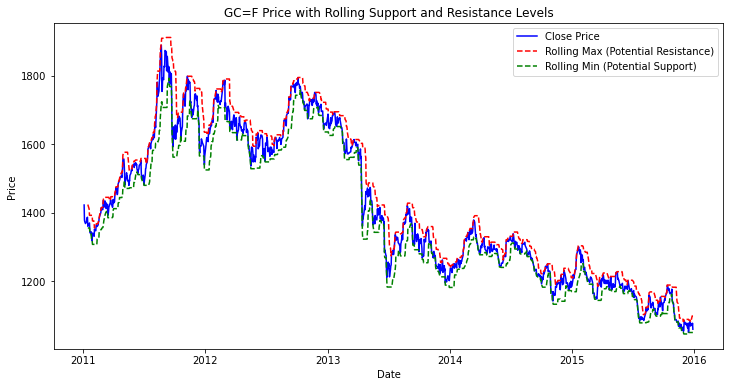

In [126]:
rolling_window = 10  # days

# Calculate rolling high and low prices
commodity_data['Rolling_Max'] = commodity_data['High'].rolling(window=rolling_window).max()
commodity_data['Rolling_Min'] = commodity_data['Low'].rolling(window=rolling_window).min()

# Plotting the prices and potential support and resistance levels
plt.figure(figsize=(12, 6))
plt.plot(commodity_data['Close'], label='Close Price', color='blue')
plt.plot(commodity_data['Rolling_Max'], label='Rolling Max (Potential Resistance)', color='red', linestyle='--')
plt.plot(commodity_data['Rolling_Min'], label='Rolling Min (Potential Support)', color='green', linestyle='--')
plt.title(f'{ticker} Price with Rolling Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [127]:
# Strategy formulation parameters
breakout_threshold = 0.01  # Threshold for confirming a breakout (1%)
stop_loss_percent = 0.03  # Stop-loss at 3%
take_profit_percent = 0.05  # Take-profit at 5%

# Initialize columns for signals
commodity_data['Buy_Signal'] = False
commodity_data['Sell_Signal'] = False
commodity_data['Stop_Loss'] = 0.0
commodity_data['Take_Profit'] = 0.0
commodity_data['In_Position'] = False

# Generate buy and sell signals based on the strategy
for i in range(1, len(commodity_data)):
    # Check if already in position from the previous day
    in_position = commodity_data['In_Position'].iloc[i-1]
    if not in_position:
        # Buy signal on breakout above resistance
        if commodity_data['Close'].iloc[i] > commodity_data['Rolling_Max'].iloc[i-1] * (1 + breakout_threshold):
            commodity_data.at[commodity_data.index[i], 'Buy_Signal'] = True
            in_position = True
    else:
        # Sell signal on breakdown below support
        if commodity_data['Close'].iloc[i] < commodity_data['Rolling_Min'].iloc[i-1] * (1 - breakout_threshold):
            commodity_data.at[commodity_data.index[i], 'Sell_Signal'] = True
            in_position = False
    
    # Set the in_position status for the day
    commodity_data.at[commodity_data.index[i], 'In_Position'] = in_position
    
    # If a new position is taken, set the stop loss and take profit
    if commodity_data['Buy_Signal'].iloc[i]:
        entry_price = commodity_data['Close'].iloc[i]
        commodity_data.at[commodity_data.index[i], 'Stop_Loss'] = entry_price * (1 - stop_loss_percent)
        commodity_data.at[commodity_data.index[i], 'Take_Profit'] = entry_price * (1 + take_profit_percent)


In [128]:


# Display a sample of the data with signals
print(commodity_data[['Close', 'Buy_Signal', 'Sell_Signal', 'Stop_Loss', 'Take_Profit']].tail(20))


                  Close  Buy_Signal  Sell_Signal  Stop_Loss  Take_Profit
Date                                                                    
2015-12-02  1054.199951       False        False        0.0          0.0
2015-12-03  1061.699951       False        False        0.0          0.0
2015-12-04  1084.500000       False        False        0.0          0.0
2015-12-07  1076.400024       False        False        0.0          0.0
2015-12-08  1076.300049       False        False        0.0          0.0
2015-12-09  1077.599976       False        False        0.0          0.0
2015-12-10  1073.099976       False        False        0.0          0.0
2015-12-11  1076.900024       False        False        0.0          0.0
2015-12-14  1064.699951       False        False        0.0          0.0
2015-12-15  1062.900024       False        False        0.0          0.0
2015-12-16  1078.000000       False        False        0.0          0.0
2015-12-17  1050.800049       False        False   

In [129]:
import pandas as pd

# Assuming your commodity_data DataFrame is already loaded and includes all the necessary columns
# commodity_data = pd.read_csv('commodity_data.csv', index_col='Date', parse_dates=True)

# Backtesting setup
initial_capital = 100000
commodity_data['Position'] = 0.0
commodity_data['Portfolio_Value'] = initial_capital
commodity_data['In_Position'] = False

# Variables to track the state of the strategy
capital = initial_capital
position = 0.0
stop_loss = 0.0
take_profit = 0.0

# Simulate trades
for i in range(1, len(commodity_data)):
    row = commodity_data.iloc[i]
    previous_row = commodity_data.iloc[i-1]
    
    # Execute buy
    if row['Buy_Signal'] and not previous_row['In_Position']:
        position = capital / row['Close']
        capital = 0.0  # All capital is now in the position
        stop_loss = row['Close'] * (1 - row['Stop_Loss'])
        take_profit = row['Close'] * (1 + row['Take_Profit'])
        commodity_data.at[commodity_data.index[i], 'In_Position'] = True

    # Execute sell if in position and a sell signal is given or stop loss/take profit is triggered
    elif previous_row['In_Position']:
        if row['Sell_Signal'] or row['Close'] <= stop_loss or row['Close'] >= take_profit:
            capital = position * row['Close']
            position = 0.0  # Position is closed
            commodity_data.at[commodity_data.index[i], 'In_Position'] = False
        else:
            # If no sell condition met, carry over the in-position status and stop-loss/take-profit levels
            stop_loss = previous_row['Stop_Loss']
            take_profit = previous_row['Take_Profit']
            commodity_data.at[commodity_data.index[i], 'In_Position'] = True

    # Update portfolio value for the day
    commodity_data.at[commodity_data.index[i], 'Position'] = position
    commodity_data.at[commodity_data.index[i], 'Portfolio_Value'] = capital + (position * row['Close'])

# Calculate final values
final_portfolio_value = commodity_data['Portfolio_Value'].iloc[-1]
total_return = final_portfolio_value - initial_capital
return_percentage = (total_return / initial_capital) * 100

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Return: {total_return}")
print(f"Return Percentage: {return_percentage}%")


Final Portfolio Value: 98061.84174542825
Total Return: -1938.1582545717538
Return Percentage: -1.938158254571754%


Breakout Trading Strategy:
Final Portfolio Value: 98061.84174542825
Total Return: -1938.1582545717538
Return Percentage: -1.938158254571754%

Buy and Hold Strategy:
Final Portfolio Value: 74518.48683951408
Total Return: -25481.51316048592
Return Percentage: -25.481513160485918%



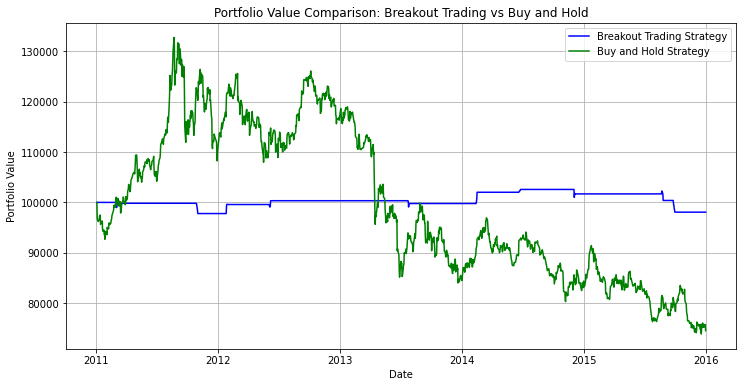

In [130]:
# Assuming the first 'Close' price is the buying price for the "Buy and Hold" strategy
buy_and_hold_initial_price = commodity_data['Close'].iloc[0]
buy_and_hold_shares = initial_capital / buy_and_hold_initial_price

# Calculate the value of the "Buy and Hold" strategy
commodity_data['Buy_and_Hold_Value'] = buy_and_hold_shares * commodity_data['Close']

# Final calculations for the Breakout Trading Strategy
breakout_final_portfolio_value = commodity_data['Portfolio_Value'].iloc[-1]
breakout_total_return = breakout_final_portfolio_value - initial_capital
breakout_return_percentage = (breakout_total_return / initial_capital) * 100

print("Breakout Trading Strategy:")
print(f"Final Portfolio Value: {breakout_final_portfolio_value}")
print(f"Total Return: {breakout_total_return}")
print(f"Return Percentage: {breakout_return_percentage}%\n")

# Final calculations for the Buy and Hold Strategy
buy_hold_final_portfolio_value = commodity_data['Buy_and_Hold_Value'].iloc[-1]
buy_hold_total_return = buy_hold_final_portfolio_value - initial_capital
buy_hold_return_percentage = (buy_hold_total_return / initial_capital) * 100

print("Buy and Hold Strategy:")
print(f"Final Portfolio Value: {buy_hold_final_portfolio_value}")
print(f"Total Return: {buy_hold_total_return}")
print(f"Return Percentage: {buy_hold_return_percentage}%\n")

# Plotting the strategy's portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(commodity_data['Portfolio_Value'], label='Breakout Trading Strategy', color='blue')
plt.plot(commodity_data['Buy_and_Hold_Value'], label='Buy and Hold Strategy', color='green')
plt.title('Portfolio Value Comparison: Breakout Trading vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()
